## Analyzing Patent Data From BindingDB

In this notebook we will use the [BindingDB database](https://bindingdb.org) to download chemical structures and data from a pharmaceutical patent. We will then use Python code to understand the relationships between chemical structure and biological data. 
1. Connect to Binding DB
2. Search BindingDB for a Patent
3. Download Structures Associated with a Patent
4. Explore the Data Associated with the Patent Structures
5. Group the Dataset By Bemis-Murcko Scaffolds
6. Associate Activity Distributions with the Scaffolds
7. Examine Molecules with the Same Scaffold
8. Create an R-Group Table to Examine Substituents on a Common Scaffold

### 1. Connect to Binding DB
We will begin by opening the BindingDB website at https://www.bindingdb.org. To download files we'll need to log in to BindingDB.  We can do this by clicking on the MyBindingDB link on the left side of the page. 

<img  
src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/patent/images/binding_db_login_1.png" alt="Drawing" width=150/>

Clicking on that link will take you to the BindingDB login page.  Enter your BindingDB username and password in the corresponding boxes and press the "Go" button.  If you don't have a BindingDB account, you can click on the "Register" link to the right of the "Go" button.  If you've forgotten your password, you can use the "Reset Password" link.   

<img  
src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/patent/images/binding_db_login_2.png" alt="Drawing" width=600/>

### 2. Search BindingDB for a Patent

Binding DB contains curated records for some United States (US) and European (WO) patents. To search for a US patent, first select "Publication", then "US Patents"

<img  
src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/patent/images/binding_db_patent_1.png" alt="Drawing" width=150/>

This will bring you to a page where you can browse recently curated patents and search by patent number. 

<img  
src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/patent/images/binding_db_patent_2.png" alt="Drawing" width=800/>

In the section below I'll show you how to download the results of your search as a 2D SD file.  If you're browsing and want to download the 2D SD file, you can just click on the **2D** link on the right side of each record in hte "Downloads" column.

### 3. Download Structures Associated with a Patent

Put **US20240109915** into the search box and press "Search". 

After a few seconds you'll see this page that allows you to browse the results. We want to download the results as an SD file.  First click on "Select All Pages", then click on "Make Dataset". 

<img  
src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/patent/images/binding_db_patent_search_1.png" alt="Drawing" width=800/>

This will take you to another page that enables downloads. The default "2D SDfile" is what we want, so just click on "Go". You may have to enter your login credentials again. 

<img  
src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/patent/images/binding_db_patent_download.png" alt="Drawing" width=800/>

BidingDB will download a file with a long random name.  In my case the file was named **35A6EC1A3C9266A38807F72D62C1E3FBki.sdf**.

### 4. Explore the Data Associated with the Patent Structures
After the download we have an SD file with 102 structures.  We'd like to get a better ideas of the relationships between chemical structure and biological activity in the patent dataset.  Now we'll use a bit of Python code to understand the data. 

We begin by installing and importing the necessary Python libraries. 

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install rdkit numpy mols2grid seaborn matplotlib requests useful_rdkit_utils

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS, rdRGroupDecomposition
from rdkit.Chem import PandasTools
# This is essential when rendering a Pandas dataframe with R-group results
PandasTools.RenderImagesInAllDataFrames(images=True)
import numpy as np
import useful_rdkit_utils as uru
import mols2grid
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import io
import base64
from IPython.display import HTML
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import pandas as pd

Read the SD file downloaded from BindingDB. For simplicity, I specified this as a url to the file I downloaded. You can change the **filename** variable in the cell below to use your own SD file.

In [3]:
url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/patent/data/35A6EC1A3C9266A38807F72D62C1E3FBki.sdf"
r = requests.get(url)
filename = "data/35A6EC1A3C9266A38807F72D62C1E3FBki.sdf"
with open(filename, "w") as ofs:
    ofs.write(r.text)
df = PandasTools.LoadSDF(filename)

There is a lot of information in the SD file, let's look at the available data fields.

In [4]:
df.columns

Index(['From', 'BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand InChI Key',
       'BindingDB MonomerID', 'BindingDB Ligand Name', 'Target Name',
       'Target Source Organism According to Curator or DataSource', 'Ki (nM)',
       'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)',
       'pH', 'Temp C', 'Curation/DataSource', 'Article DOI',
       'BindingDB Entry DOI', 'PMID', 'PubChem AID', 'Patent Number',
       'Authors', 'Institution', 'Link to Ligand in BindingDB',
       'Link to Ligand-Target Pair in BindingDB', 'Ligand HET ID in PDB',
       'PDB ID(s) for Ligand-Target Complex', 'PubChem CID', 'PubChem SID',
       'ChEBI ID of Ligand', 'ChEMBL ID of Ligand', 'DrugBank ID of Ligand',
       'IUPHAR_GRAC ID of Ligand', 'KEGG ID of Ligand', 'ZINC ID of Ligand',
       'Number of Protein Chains in Target (bigger than 1 implies a multichain complex)',
       'BindingDB Target Chain Sequence', 'PDB ID(s) of Target Chain',
       'UniProt (SwissProt) Recommen

There are 4 fields that could potentially hold biological data. 

In [5]:
activity_cols = ['Ki (nM)','IC50 (nM)', 'Kd (nM)', 'EC50 (nM)']

Let's see how many of these fields actually contain data.  Note that the only populated field is "IC50 (nM)" which has 102 records.  Recall that the 102 structures were curated from the patent. 

In [6]:
df[activity_cols].replace('', np.nan).count()

Ki (nM)        0
IC50 (nM)    102
Kd (nM)        0
EC50 (nM)      0
dtype: int64

Examine at the IC50 values.  Note that these values currently stored as text strings.  This isn't very useful if we want to do any sort of analysis.  We'll fix this below. 

In [7]:
df["IC50 (nM)"].values

array([' 0.900', ' 1.30', ' 1.30', ' 1.50', ' 1.80', ' 2.20', ' 2.40',
       ' 2.40', ' 2.60', ' 3.10', ' 3.10', ' 3.10', ' 3.20', ' 3.40',
       ' 3.50', ' 3.50', ' 3.60', ' 3.60', ' 3.90', ' 3.90', ' 4.00',
       ' 4.10', ' 4.40', ' 4.50', ' 4.60', ' 4.60', ' 4.90', ' 5.10',
       ' 5.20', ' 5.20', ' 5.30', ' 5.40', ' 5.40', ' 5.50', ' 5.60',
       ' 5.80', ' 6.10', ' 6.20', ' 6.20', ' 6.30', ' 6.40', ' 6.40',
       ' 6.60', ' 6.70', ' 7.00', ' 7.10', ' 7.20', ' 7.20', ' 7.30',
       ' 7.60', ' 7.60', ' 7.90', ' 8.00', ' 8.60', ' 9.40', ' 9.60',
       ' 9.60', ' 9.90', ' 10.00', ' 10.1', ' 10.6', ' 11.0', ' 11.1',
       ' 11.1', ' 11.7', ' 11.8', ' 12.3', ' 12.9', ' 13.0', ' 13.4',
       ' 13.6', ' 14.0', ' 14.3', ' 15.0', ' 15.3', ' 16.1', ' 17.6',
       ' 17.9', ' 18.1', ' 19.5', ' 19.7', ' 19.7', ' 22.4', ' 22.9',
       ' 23.2', ' 23.2', ' 23.3', ' 26.1', ' 27.3', ' 29.5', ' 30.1',
       ' 33.6', ' 45.5', ' 46.5', ' 65.4', ' 85.9', ' 92.6', ' 109',
       ' 115', ' 18

Change the datatype of the IC50 field from **object**, which is essentially a text string, to **float**.

In [8]:
df["IC50 (nM)"] = df["IC50 (nM)"].astype(float)

We would like to understand the distribution of activity values in the patent.  To do this we can plot a distribution histogram using the [displot](https://seaborn.pydata.org/generated/seaborn.displot.html) function in Pandas.  However, the plot below isn't very helpful.  The IC50 values range from 0.9 to 10,000 nM, this is a huge range that doesn't lend itself well to a plot. 

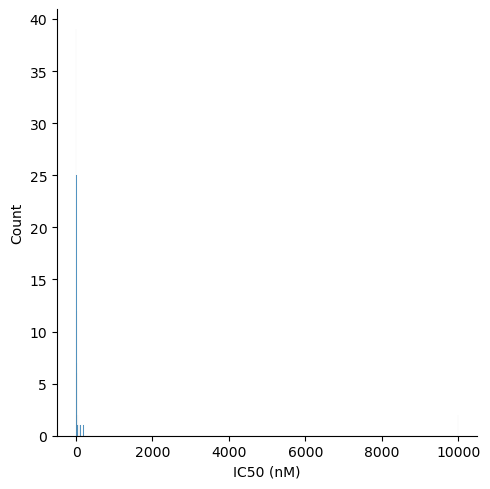

In [9]:
sns.displot(df["IC50 (nM)"]);

A more useful approach is to examine the distribution on a log scale.  Let's create a new column in the dataframe with the negative log the IC50 as the **pIC50**. 

In [10]:
df['pIC50'] = -np.log10(df["IC50 (nM)"] * 1e-9)

The plot below looks a lot better and shows the activity distribution. 

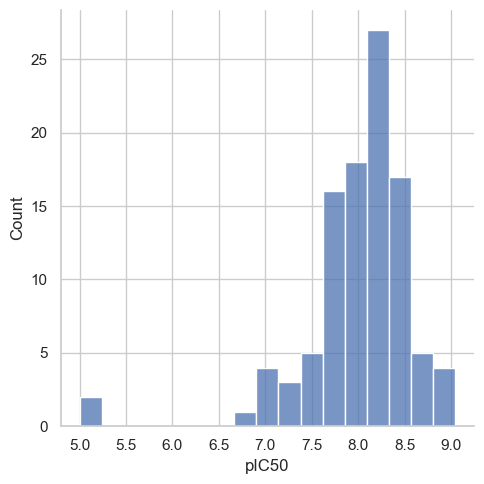

In [11]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.displot(df.pIC50);

### 5. Group the Dataset By Bemis-Murcko Scaffolds

To get a quick overview of the structures in the patent, we can reduce the structures to [Bemis-Murcko scaffolds](https://rdkit.org/docs/source/rdkit.Chem.Scaffolds.MurckoScaffold.html). 

In [12]:
df['SMILES'] = df.ROMol.apply(Chem.MolToSmiles)
df['scaffold_smi'] = df.SMILES.apply(Chem.Scaffolds.MurckoScaffold.MurckoScaffoldSmiles)

Create a new dataframe with the unique Bemis-Murcko scaffolds and the number of molecules with tha scaffold in the initial dataset. 

/Users/pwalters/miniconda3/envs/rdkit_2023_05/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,scaffold_smi,count,mol
0,O=C1CC2(CCN(C(=O)c3ccc4[nH]ncc4c3)CC2)Cc2scnc21,13,
1,O=C1CC2(CCN(C(=O)c3ccc4ncccc4c3)CC2)Cc2scnc21,13,
2,O=C1CC2(CCN(C(=O)c3ccc4[nH]ccc4c3)CC2)Cc2scnc21,9,
3,O=C1CC2(CCN(C(=O)c3ccc4cc[nH]c4c3)CC2)Cc2scnc21,8,
4,O=C1CC2(CCN(C(=O)c3ccc4ccccc4c3)CC2)Cc2scnc21,8,

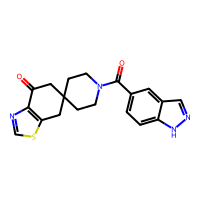
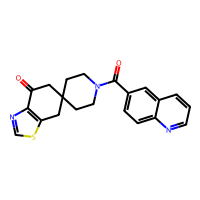
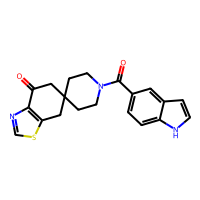
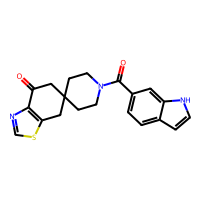
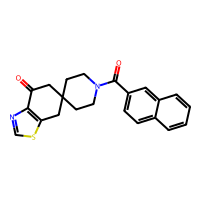

In [13]:
scaffold_df = uru.value_counts_df(df,"scaffold_smi")
scaffold_df['mol'] = scaffold_df.scaffold_smi.apply(Chem.MolFromSmiles)
[rdDepictor.Compute2DCoords(m) for m in scaffold_df.mol]
scaffold_df.head()

We can use a simple plot to visualize the number of molecules with each scaffold.  The plot below, the 25 scaffolds are arrayed on the x-axis.  The y-axis shows the number of examples molecules with each scaffold.  We can see that scaffolds 0 and 1 have 13 molecules, scaffold 2 has 9 examples, etc. 

Text(0, 0.5, 'Number of Examples')

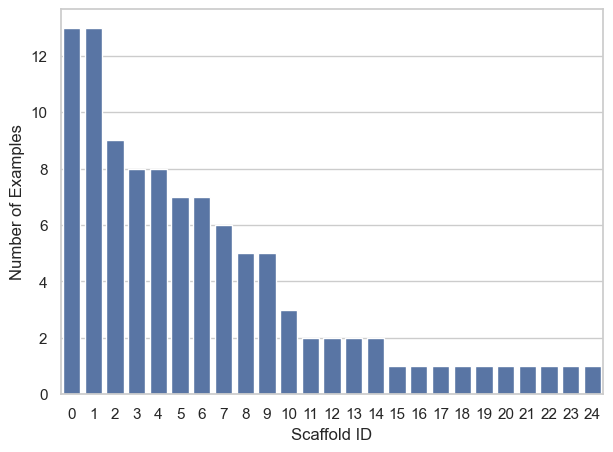

In [14]:
sns.set(rc={'figure.figsize': (7, 5)})
sns.set_style('whitegrid')
ax = sns.barplot(x=range(0,len(scaffold_df)),y=scaffold_df["count"].values)
ax.set_xlabel("Scaffold ID")
ax.set_ylabel("Number of Examples")

### 6. Associate Activity Distributions with the Scaffolds

It's useful to examine the activity distributions associated with each of the scaffolds.  To do this, we'll display a table with the scaffold, the number of molecules with that scaffold, and a box plot showing the associated activity distributions. To make life easier, we will define a couple of support functions. 

In [15]:
def boxplot_base64_image(dist: np.ndarray, x_lim: list[int] = [0, 10]) -> str:
    """
    Plot a distribution as a seaborn boxplot and save the resulting image as a base64 image.

    Parameters:
    dist (np.ndarray): The distribution data to plot.
    x_lim (list[int]): The x-axis limits for the boxplot.

    Returns:
    str: The base64 encoded image string.
    """
    sns.set(rc={'figure.figsize': (3, 1)})
    sns.set_style('whitegrid')
    ax = sns.boxplot(x=dist)
    ax.set_xlim(x_lim[0], x_lim[1])
    s = io.BytesIO()
    plt.savefig(s, format='png', bbox_inches="tight")
    plt.close()
    s = base64.b64encode(s.getvalue()).decode("utf-8").replace("\n", "")
    return '<img align="left" src="data:image/png;base64,%s">' % s


def mol_to_base64_image(mol: Chem.Mol) -> str:
    """
    Convert an RDKit molecule to a base64 encoded image string.

    Parameters:
    mol (Chem.Mol): The RDKit molecule to convert.

    Returns:
    str: The base64 encoded image string.
    """
    drawer = rdMolDraw2D.MolDraw2DCairo(300, 150)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    text = drawer.GetDrawingText()
    im_text64 = base64.b64encode(text).decode('utf8')
    img_str = f"<img src='data:image/png;base64, {im_text64}'/>"
    return img_str

With the functions above we can define this table with a few lines of code. One could argue that I should have labeled the x-axis on the boxplots below.  However, I feel that adds a lot of excess visual noise. 

/Users/pwalters/miniconda3/envs/rdkit_2023_05/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]



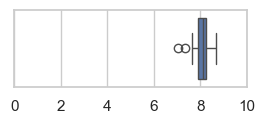
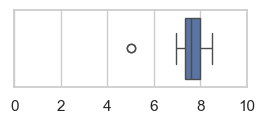
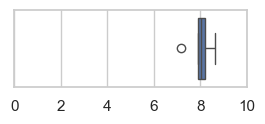
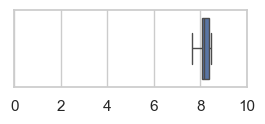
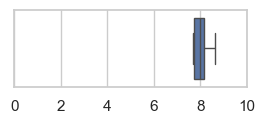
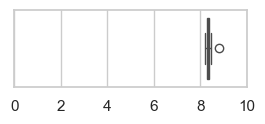
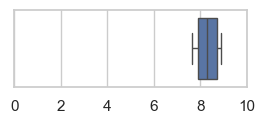
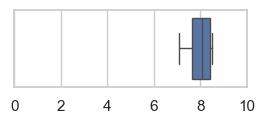
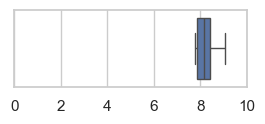
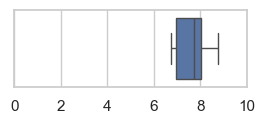

In [16]:
rows_to_display = 10
tmp_df = scaffold_df.head(rows_to_display).copy()
tmp_df['mol_img'] = tmp_df.mol.apply(mol_to_base64_image)
img_list = []
for smi in tmp_df.scaffold_smi:
    img_list.append(boxplot_base64_image(df.query("scaffold_smi == @smi").pIC50.values))
tmp_df['dist_img'] = img_list
HTML(tmp_df[['mol_img','count','dist_img']].to_html(escape=False))

### 7. Examine Molecules with the Same Scaffold
After looking the figure above, we may want to perform a more detailed analysis of the molecules in each of the scaffold groups above. By changing the **scaffold_id** field below we can view different sets of molecules with the same scaffold. The data is sorted by **IC50 (nM)**.  To facilitate SAR analysis we've aligned the structures to the scaffolds in table above. 

In [17]:
scaffold_id = 1
scaffold_smi = scaffold_df.scaffold_smi.values[scaffold_id]
tmp_df = df.query("scaffold_smi == @scaffold_smi").copy()
tmp_df['mol'] = tmp_df.SMILES.apply(Chem.MolFromSmiles)
scaffold_mol = scaffold_df.mol.values[scaffold_id]
AllChem.Compute2DCoords(scaffold_mol)
[AllChem.GenerateDepictionMatching2DStructure(m,scaffold_mol) for m in tmp_df.mol]
mols2grid.display(tmp_df.sort_values("IC50 (nM)"),size=(175,175),subset=["img","IC50 (nM)"], mol_col="mol",
                  use_coords=True, prerender=True)

MolGridWidget()

### 8. Create an R-Group Table to Examine Substituents on a Common Scaffold

Another way to examine the data in a patent is to create a table of substituents attached at a different positions on a common scaffold.  This often provides a simple way of identifying the preferred substituents at each position. 
To do this, we first need to find the substructure that is common to all the molecules.  This is commonly referred to as the Maximum Common Substructure or MCSS.  For a deeper view of MCSS methods and how they are used in the RDKit, please consult this excellent [tutorial](https://projects.volkamerlab.org/teachopencadd/talktorials/T006_compound_maximum_common_substructures.html) from the Teach Open CADD collection. We can use the **rdFMCS.FindMCS** method to find the MCSS for the 102 molecules in our patent. For more information about R-group decompositions in the RDKit, I highly recommend [this](https://greglandrum.github.io/rdkit-blog/posts/2023-01-09-rgd-tutorial.html) blog post from Greg Landrum.

In [18]:
mcs_res = rdFMCS.FindMCS(df.ROMol.values)

The MCSS is returned as SMARTS, which has limited utility for us. 

In [19]:
mcs_res.smartsString

'[#6]12:[#6](-[#6]-[#6]3(-[#6]-[#6]-1)-[#6]-[#6]-[#7](-[#6]-[#6]-3)-[#6](-[#6]:[#6]:[#6]:,-[#6]:,-[#6]:,-[#6])=[#8]):[#16]:[#6](:[#7]:2)-[#6]-[#6]'

However, we can convert the SMARTS to an RDKit molecule, which we can visualize.  Note that this molecule is close, but not exactly what we want. There is a partial aromatic ring on the left side of the molecule and there's a substituent on the thiazole ring on the right.  

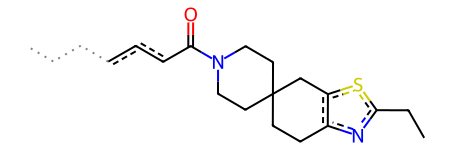

In [20]:
Chem.MolFromSmarts(mcs_res.smartsString)

However, with a quick bit of structure editing, we have a more reasonable core (scaffold) SMILES and an associated RDKit molecule. 

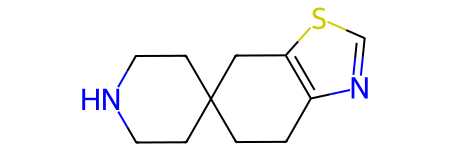

In [21]:
core_smi = "C1CC2(CCN1)CCc1ncsc1C2"
core_mol = Chem.MolFromSmiles(core_smi)
core_mol

Now that we have our core molecule, we can use the RDKit go perform an R-group decomposition. 

The RDkit has a couple of ways of returning the results of an R-group decomposition.  If you want to view the results in a dataframe, call **RGrouDescompose wiht **asRows=False**.  Also remember to set **PandasTools.RenderImagesInAllDataFrames(images=True)** as we did in the imports section of this notebook. 

/Users/pwalters/miniconda3/envs/rdkit_2023_05/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Mol,R1,R2,R3
0,,,,
1,,,,
2,,,,
3,,,,
4,,,,

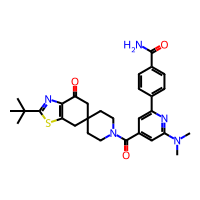
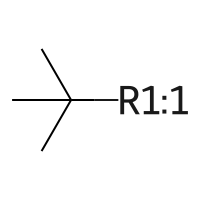
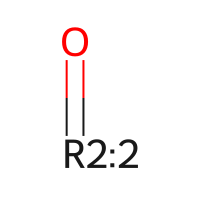
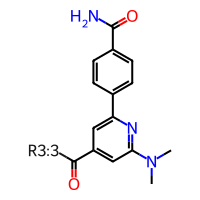
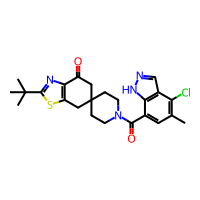
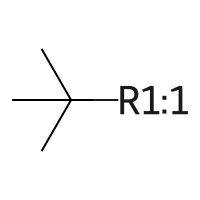
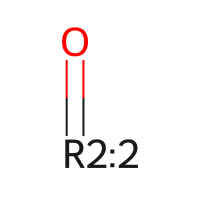
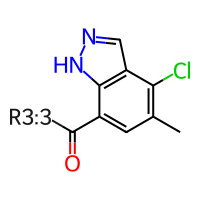
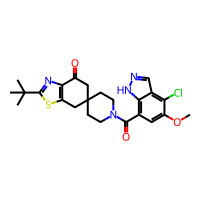
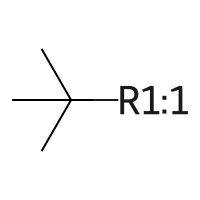
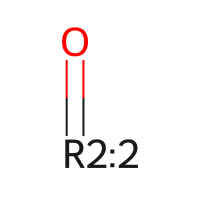
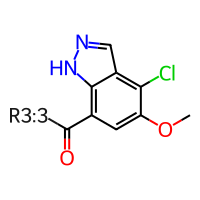
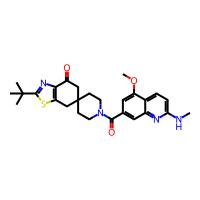
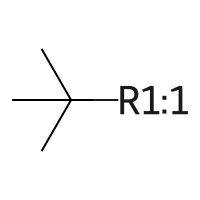
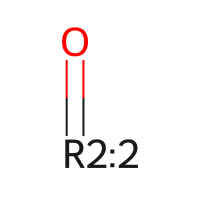
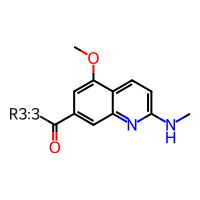
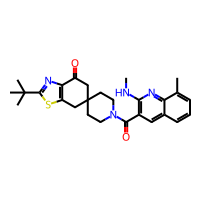
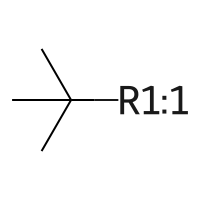
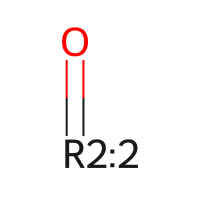
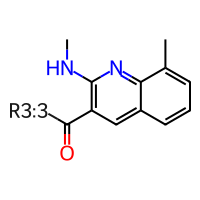

In [22]:
mols = df.ROMol
crgd,fails = rdRGroupDecomposition.RGroupDecompose([core_mol],mols,asRows=False)
PandasTools.RGroupDecompositionToFrame(crgd,[mols[i] for i in range(len(mols)) if i not in fails],).head()

If we're going to do some analysis with the results of the R-group decomposition, we call **rdRGroupDecomposition** with **asRows=True**. 

In [23]:
mols = df.ROMol.values
rgd,fails = rdRGroupDecomposition.RGroupDecompose([core_mol],mols,asRows=True)

The **rdRGroupDecomposition.RGroupDecompose** method returns two values.  The first is a dictionary of cores and R-groups for the decomposed molecules.  We'll get to this in a minute.  First let's look at the variable **fails**, which contains the molecules that failed the R-group decompositon. We can see below that **fails** contains an empty list, indicating that the R-group decomposition succeeded for all the molecules.

In [24]:
fails

[]

We called **rdRGroupDecomposition.RGroupDecompose** with **asRows=True**, so the variable **rgd** contains a list of dictionaries containing the core and R-groups for each molecule. Let's look at the first entry in the list **rgd**. We can see that the dictionary contains a core and 3 R-groups as RDKit molecules. 

In [25]:
rgd[0]

{'Core': <rdkit.Chem.rdchem.Mol at 0x30b26e500>,
 'R1': <rdkit.Chem.rdchem.Mol at 0x30b26f370>,
 'R2': <rdkit.Chem.rdchem.Mol at 0x30b26eff0>,
 'R3': <rdkit.Chem.rdchem.Mol at 0x30b26f140>}

Here's the core, which also shows where the substituents are attached. 

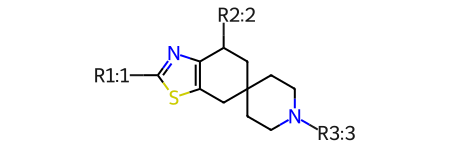

In [26]:
rgd[0]['Core']

As discussed above, R-group decomposition transformed the molecules, into a list of dictionaries containing the R-groups as RDKit molecules.  As a next step, we would like to find the most frequently used substituents at R1, R2, and R3.  To do this, we first need to transform the substitutent molecules into SMILES.  The code below loops over the rows in **rgd** and transforms each substituent molecule into SMILES.  We can then take the list we compiled and turn it into a Pandas dataframe. 

In [27]:
cols = sorted(rgd[0].keys())
rgsmi_list = []
for row in rgd:
    rgsmi_list.append([Chem.MolToSmiles(row[x]) for x in cols])
rgsmi_df = pd.DataFrame(rgsmi_list,columns=cols)

The dataframe contains columns for the Core, R1, R2, and R3.  

In [ ]:
rgsmi_df

Now that we have the data in a data frame we can use the Pandas [value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) function to list the frequencies for each distinct substituent.  The function **value_counts_df** from the [useful_rdkit_utils](https://useful-rdkit-utils.readthedocs.io/en/latest/) package is just a simple wrapper that transforms the results of **value_counts** into a dataframe. 

In [ ]:
core_count_df = uru.value_counts_df(rgsmi_df,"Core") 
core_count_df

We can use mols2grid to display the cores extracted by the R-group decomposition and their frequencies.  The number below each structure is the number of time that core or R-group occurred. It's interesting that we have two different cores.  Looking at the structures, they appear to be the same.  I think this is a glitch somewhere in the RDKit.  It doesn't affect anything below, so we don't have to worry about it. 

In [ ]:
mols2grid.display(core_count_df,smiles_col="Core",template="static",prerender=True,size=(175,175),
                 subset=["img","count"])

To simplify the work below, we'll wrap the two steps above into a function.  We can then use the output of this function to look at which R-groups are used most frequently. 

In [ ]:
def tablulate_rgroups(df_in,rgroup_name, max_rows=10):
    count_df = uru.value_counts_df(df_in,rgroup_name)
    return mols2grid.display(count_df.head(max_rows),smiles_col=rgroup_name,template="static",prerender=True,size=(125,125),
                 subset=["img","count"])

Tabulate the R1 groups, note that t-butyl occurs in 94 molecules, far more than any other R-group.

In [ ]:
tablulate_rgroups(rgsmi_df,"R1")

Tabulate R2, it's almost always the ketone.

In [ ]:
tablulate_rgroups(rgsmi_df,"R2")

Tabulate R3, note that there a lot more variation here. Also note that we're sorting by frequency and only showing the first 10.

In [ ]:
tablulate_rgroups(rgsmi_df,"R3")

### Hidden Bonus Trick
For those who stayed until the end, here's a cool trick. The original dataframe **df** and the dataframe with the R-group SMILES **rg_smi_df** are in the same order.  We can concatenate the two dataframes and look at the activity distributions associated with specific R-groups.  For instance, let's say we want to tabulate the activity distributions for the 5 most frequently occurring R3 groups.  We start by combining the two dataframes, note that we use **axis=1** to concatenate columns. 

In [ ]:
combo_df = pd.concat([df,rgsmi_df],axis=1)

As we did above, we'll create a dataframe to look at the frequency of R3 groups. 

In [ ]:
r3_count_df = uru.value_counts_df(rgsmi_df,"R3")
r3_count_df

Use the same approach we used above to tabulate activity associated with scaffolds to compile a table of R3 groups and associated activity distributions. 

In [ ]:
img_list = []
for rg_smi in r3_count_df.head(5).R3:
    ic50_list = combo_df.query('R3 == @rg_smi')["IC50 (nM)"].astype(float).values
    rg_mol = Chem.MolFromSmiles(rg_smi)
    mol_img = mol_to_base64_image(rg_mol)
    ic50_img = boxplot_base64_image(ic50_list,x_lim=[0,20])
    img_list.append([mol_img, len(ic50_list),ic50_img])
img_df = pd.DataFrame(img_list,columns=["R-Group","Count","IC50 (nM)"])
HTML(img_df.to_html(escape=False))